# Machine Learning Project

## (Kernel) Ridge Regression

### Necessary classes and functions

In [288]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge

In [289]:
# Training and test set split

def train_test_split_manual(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle the indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # Calculate the split index
    split_index = int((1 - test_size) * X.shape[0])

    # Split the data
    X_train, X_test = X.iloc[indices[:split_index]], X.iloc[indices[split_index:]]
    y_train, y_test = y.iloc[indices[:split_index]], y.iloc[indices[split_index:]]

    return X_train, X_test, y_train, y_test

In [290]:
# Ridge regression with hyperparameter with fit and predict method

class RidgeRegression:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Regularization parameter
        self.coef_ = None    # Regression coefficients
        self.intercept_ = None  # Intercept term

    def fit(self, X, y):
        # Augmenting the input matrix X with a column of ones for the intercept term
        X_augmented = np.c_[np.ones(X.shape[0]), X]

        # Identity matrix with size equal to the number of features
        identity_matrix = np.identity(X_augmented.shape[1])

        # Compute the closed-form solution for ridge regression
        coef_matrix = np.linalg.inv(X_augmented.T @ X_augmented + self.alpha * identity_matrix) @ X_augmented.T @ y

        # Extract coefficients and intercept
        self.intercept_ = np.array(coef_matrix)[0]
        self.coef_ = np.array(coef_matrix)[1:]

    def predict(self, X):
        # Augmenting the input matrix X with a column of ones for the intercept term
        X_augmented = np.c_[np.ones(X.shape[0]), X]

        # Predicting the target values
        y_pred = X_augmented @ np.concatenate(([self.intercept_], self.coef_))

        return y_pred

# Example usage
# Assume X_train and y_train are your training data
# ridge_model = RidgeRegression(alpha=0.1)
# ridge_model.fit(X_train, y_train)

# Make predictions on test data
# y_pred = ridge_model.predict(X_test)

In [291]:
# Root mean squared error
def root_mean_squared_error(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [292]:
# "Model" for using the average as predictor
class MeanModel:
    def __init__(self):
        self.y_mean = None
        pass

    def fit(self, X, y):
        self.y_mean = np.mean(y)
        pass
        
    def predict(self, X):
        y_pred = pd.Series([self.y_mean] * X.shape[0])
        return y_pred

In [293]:
def k_fold_cross_validation(model, X, y, k=5, evaluation_method='mse', random_state=None):
    """
    Perform K-fold cross-validation.

    Parameters:
    - model: The machine learning model to be evaluated.
    - X: The feature matrix.
    - y: The target variable.
    - k: The number of folds (default is 5).
    - random_state: Seed for randomization (optional).

    Returns:
    - List of evaluation metrics for each fold.
    """

    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    fold_size = len(X) // k
    evaluation_metrics_test = []
    evaluation_metrics_train = []

    # mse_estimates = []
    # rmse_estimates = []
    # r2_estimates = []

    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train, X_test = X.iloc[train_indices, ], X.iloc[test_indices, ]
        y_train, y_test = y.iloc[train_indices, ], y.iloc[test_indices, ]

        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)

        # Evaluate the model according to the chosen method
        if evaluation_method == 'mse':
            evaluation_metric_test = mean_squared_error(y_test, y_test_pred)
            evaluation_metric_train = mean_squared_error(y_train, y_train_pred)
        elif evaluation_method == 'rmse':
            evaluation_metric_test = root_mean_squared_error(y_test, y_test_pred)
            evaluation_metric_train = root_mean_squared_error(y_train, y_train_pred)
        elif evaluation_method == 'r2':
            evaluation_metric_test = r2_score(y_test, y_test_pred)
            evaluation_metric_train = r2_score(y_train, y_train_pred)

        # mse = mean_squared_error(y_test, y_pred)
        # rmse = np.sqrt(mse)
        # r2 = r2_score(y_test, y_pred)

        evaluation_metrics_test.append(evaluation_metric_test)
        evaluation_metrics_train.append(evaluation_metric_train)

        # mse_estimates.append(mse)
        # rmse_estimates.append(rmse)
        # r2_estimates.append(r2)

    return evaluation_metrics_test, evaluation_metrics_train
    # return mse_estimates, rmse_estimates, r2_estimates

In [294]:
# Nested cross-validation

def nested_cross_validation(X, y, k=5, alpha_list = np.linspace(0, 1, num=11), evaluation_method='rmse', random_state=None):
    """
    Perform nested K-fold cross-validation with Ridge regression.

    Parameters:
    - X: The feature matrix.
    - y: The target variable.
    - k: The number of folds (default is 5).
    - random_state: Seed for randomization (optional).

    Returns:
    - nested_cv_estimate: Risk estimate
    - best_hyper_par_list: List of the best hyper parameter for each outer fold
    - errors: Errors for each outer fold
    """

    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    fold_size = len(X) // k
    errors = []

    best_hyper_par_list = []

    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train, X_test = X.iloc[train_indices, ], X.iloc[test_indices, ]
        y_train, y_test = y.iloc[train_indices, ], y.iloc[test_indices, ]

        cv_estimates = {}

        for j in alpha_list:
            evaluation_metrics = k_fold_cross_validation(RidgeRegression(alpha=j), X=X_train, y=y_train, k=5, evaluation_method=evaluation_method, random_state=None)[0]
            cv_estimate = np.mean(evaluation_metrics)
            cv_estimates[j] = cv_estimate
        
        best_hyper_par = max(cv_estimates, key=cv_estimates.get) if evaluation_method=='r2' else min(cv_estimates, key=cv_estimates.get)
        best_hyper_par_list.append(best_hyper_par)
        best_hyper_par_model = RidgeRegression(alpha=best_hyper_par)
        best_hyper_par_model.fit(X=X_train, y=y_train)
        y_pred = best_hyper_par_model.predict(X=X_test)

        # Evaluate the model according to the chosen method
        if evaluation_method == 'mse':
            error = mean_squared_error(y_test, y_pred)
        elif evaluation_method == 'rmse':
            error = root_mean_squared_error(y_test, y_pred)
        elif evaluation_method == 'r2':
            error = r2_score(y_test, y_pred)
        
        # error = mean_squared_error(y_true=y_test, y_pred=y_pred)
        errors.append(error)

    nested_cv_estimate = np.mean(errors)

    return nested_cv_estimate, best_hyper_par_list, errors

### Import data and examine it

In [295]:
file_path = "dataset.csv"

df = pd.read_csv(file_path)

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [297]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [298]:
df.describe().round(2)

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00,114000.00
mean,56999.50,33.24,228029.15,0.57,0.64,5.31,-8.26,0.64,0.08,0.31,0.16,0.21,0.47,122.15,3.90
std,32909.11,22.31,107297.71,0.17,0.25,3.56,5.03,0.48,0.11,0.33,0.31,0.19,0.26,29.98,0.43
min,0.00,0.00,0.00,0.00,0.00,0.00,-49.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,28499.75,17.00,174066.00,0.46,0.47,2.00,-10.01,0.00,0.04,0.02,0.00,0.10,0.26,99.22,4.00
50%,56999.50,35.00,212906.00,0.58,0.68,5.00,-7.00,1.00,0.05,0.17,0.00,0.13,0.46,122.02,4.00
75%,85499.25,50.00,261506.00,0.70,0.85,8.00,-5.00,1.00,0.08,0.60,0.05,0.27,0.68,140.07,4.00
max,113999.00,100.00,5237295.00,0.98,1.00,11.00,4.53,1.00,0.96,1.00,1.00,1.00,1.00,243.37,5.00


## Preprocessing

We check for duplicate songs (this is due to songs appearing on an album and as a single seperately for example).

In [299]:
# Remove duplicate songs
track_id_duplicates = sum(df['track_id'].duplicated())
print("Number of duplicates:", track_id_duplicates)
# 24258 duplicate tracks

df = df.drop_duplicates(subset=['track_id'])
df.reset_index(drop=True, inplace=True)

# new N
print("Remaining Observations:", df.shape[0])

Number of duplicates: 24259
Remaining Observations: 89741


### Dealing with categorical data

The following variables are categorical:
- 'track_id'
- 'artists'
- 'album_name'
- 'track_name'
- 'explicit'
- 'key'
- 'mode'
- 'track_genre'

The variable 'track_id' cannot provide us with any information regarding track popularity so we leave it out. 

Information on the artists performing a track (variable 'artists') definitely can give us information about the track popularity but since we have 31437 unique artists in our data (although this includes collaborations) one-hot encoding would be extremely memory-intensive. Another option was considered: calculating the artist popularity by taking the mean popularity of all tracks of an artist and including it in the model. A quick analysis showed that this greatly improves the predictive power of the model but since about 2/3 of all artists included in the data only have one single track, artist popularity is often equal to track popularity, therefore this approach was discarded. A similar approach would be to put artists into popularity categories like low, medium and high popularity and using this measure in our model, but since this is basically just a more fuzzy version of the former approach, still including lots of information from our target variable, this was also not used and the variable 'artists' was also discarded for the model.

For similar reasons the variable 'album_name' was also discarded.

For the variable 'track_name' using the length of the track name as a feature in the model was considered, the thought process being that listeners find shorter, simple track names more appealing than long, complicated names, but since no correlation was found between popularity and track name lenght, this idea, and with it the variable 'track_name', was also discarded.

The variable 'explicit' is boolean and was simple transformed to integer for technical reasons.

The variable 'key' gives information about the key the track is in and is already pre-encoded so that integers map to pitches. The result is a ordinal variable that shouldn't require any special transformations and will therefore be included as is in the model.

The variable 'mode' indicates the modality (major or minor) of a track with 0 indicating minor and 1 major. No transformation is needed for this variable.

For the variable 'track_genre' a simple one-hot encoding was chosen since the number of genres is high but still managable with 113 unique genres.
An alternative model that relies purely on sonic features (and 'explicit') without the variable 'track_genre' will also be tested. 

In [300]:
# Variable 'explicit'
# Converting from boolean to integer
df['explicit'] = df['explicit'].astype(int)

In [301]:
# Use groupby to group the DataFrame by 'artists' and count the number of tracks for each artist
tracks_per_artist = df['artists'].value_counts().reset_index()

# Rename the columns to make them more descriptive
tracks_per_artist.columns = ['artist', 'track_count']

# Print the DataFrame with the number of tracks for each artist
print(tracks_per_artist)
      
# Mean number of tracks per artist
print('Average number of tracks:', tracks_per_artist['track_count'].mean())

# Artists with just one track
print('Number of artists with just one track in the data:', tracks_per_artist[tracks_per_artist['track_count'] == 1].shape[0])

                                   artist  track_count
0                            George Jones          260
1                       my little airport          171
2                             The Beatles          149
3                                     BTS          143
4                         Håkan Hellström          141
...                                   ...          ...
31432    Critical Mass;D-Block & S-te-Fan            1
31433                   Klubfiller;Re-Con            1
31434              Dj Gizmo;The Darkraver            1
31435  Rotterdam Terror Corps;Mike Redman            1
31436                       Jesus Culture            1

[31437 rows x 2 columns]
Average number of tracks: 2.8545980850590067
Number of artists with just one track in the data: 20150


In [302]:
# Overall artist popularity by mean track popularity
artist_popularity = df.groupby('artists')['popularity'].mean().reset_index()

artist_popularity.columns = ['artists', 'artist_popularity']

# Print the DataFrame with mean popularity for each artist
print(artist_popularity)

# Add artist_popularity
# df = df.merge(artist_popularity, on='artists', how='left')

                                                 artists  artist_popularity
0                                                 !nvite          23.000000
1                                  "Puppy Dog Pals" Cast          57.500000
2                                    "Weird Al" Yankovic          26.333333
3      #Kids;Nursery Rhymes;Nursery Rhymes and Kids S...          34.000000
4                                                 $affie          39.000000
...                                                  ...                ...
31432                                                黃仲崑          24.333333
31433                                                 黃妃          24.000000
31434                                                黃小琥          56.000000
31435                                                黃敏華          20.000000
31436                                            龍藏Ryuzo          21.500000

[31437 rows x 2 columns]


In [303]:
# Use groupby to group the DataFrame by 'artists' and count the number of tracks for each genre
tracks_per_genre = df['track_genre'].value_counts().reset_index()

# Rename the columns to make them more descriptive
tracks_per_genre.columns = ['track_genre', 'track_count']

# Print the DataFrame with the number of tracks for each genre
print(tracks_per_genre)
      
# Mean number of tracks per genre
print('Average number of tracks:', tracks_per_genre['track_count'].mean())

# Artists with just one track
print('Number of genres with just one track in the data:', tracks_per_genre[tracks_per_genre['track_count'] == 1].shape[0])

    track_genre  track_count
0      acoustic         1000
1      alt-rock          999
2         tango          999
3       ambient          999
4      afrobeat          999
..          ...          ...
108       metal          232
109        punk          226
110       house          210
111       indie          134
112   reggaeton           74

[113 rows x 2 columns]
Average number of tracks: 794.1681415929204
Number of genres with just one track in the data: 0


In [304]:
# Overall genre popularity by mean track popularity
genre_popularity = df.groupby('track_genre')['popularity'].mean().reset_index()

genre_popularity.columns = ['track_genre', 'genre_popularity']

# Print the DataFrame with mean popularity for each genre
print(genre_popularity)

# Add genre_popularity
# df = df.merge(genre_popularity, on='track_genre', how='left')

     track_genre  genre_popularity
0       acoustic         42.483000
1       afrobeat         24.407407
2       alt-rock         33.896897
3    alternative         22.218673
4        ambient         44.208208
..           ...               ...
108       techno         40.060096
109       trance         38.550847
110     trip-hop         34.386062
111      turkish         40.508046
112  world-music         41.536295

[113 rows x 2 columns]


In [305]:
df.dropna(inplace=True)

In [306]:
# Variable 'genre'
# One-hot encoding by creating dummies for every possible genre
df = pd.get_dummies(data=df, columns=['track_genre'], drop_first=True, dtype=int)
# Drop one to avoid the dummy variable trap
# First in this case which is acoustic

In [307]:
columns_to_drop = ['Unnamed: 0','track_id','artists','album_name','track_name']
df.drop(columns=columns_to_drop, inplace=True)

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89740 entries, 0 to 89740
Columns: 127 entries, popularity to track_genre_world-music
dtypes: float64(9), int64(118)
memory usage: 87.6 MB


In [309]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[df.columns] = scaler.fit_transform(df[df.columns])

In [310]:
df.describe().round(2)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
count,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00,...,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00,89740.00
mean,0.33,0.04,0.09,0.57,0.63,0.48,0.76,0.64,0.09,0.33,...,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.01
std,0.21,0.02,0.28,0.18,0.26,0.32,0.10,0.48,0.12,0.34,...,0.10,0.10,0.09,0.10,0.10,0.07,0.09,0.10,0.10,0.10
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.19,0.03,0.00,0.46,0.46,0.18,0.73,0.00,0.04,0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.33,0.04,0.00,0.58,0.68,0.45,0.78,1.00,0.05,0.19,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.49,0.05,0.00,0.70,0.85,0.73,0.82,1.00,0.09,0.63,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Correlations

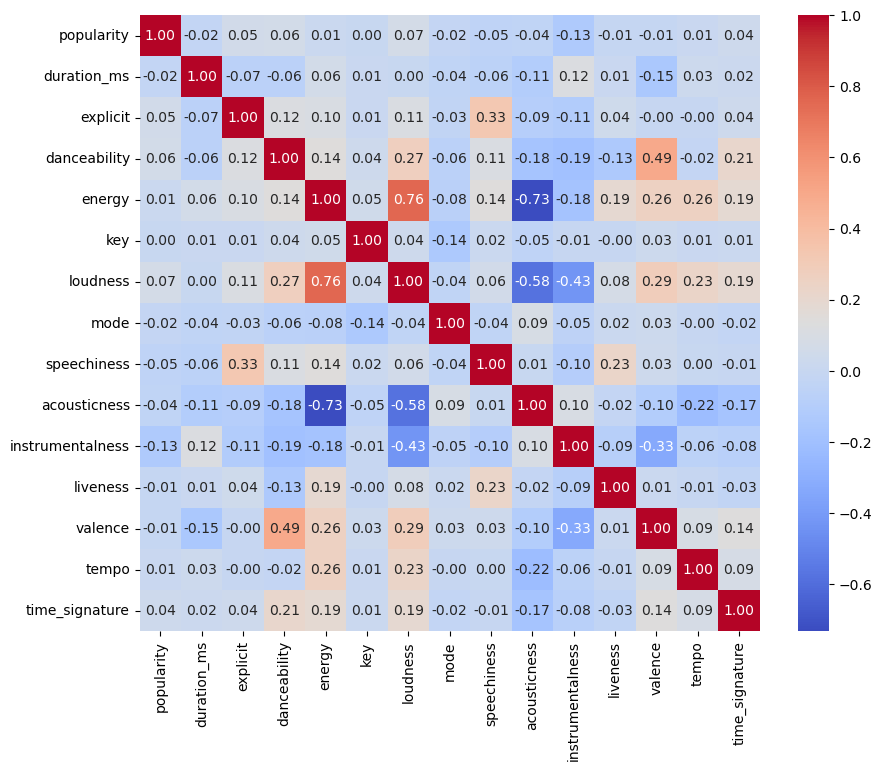

In [311]:
# Filter out columns starting with 'track_genre'
filtered_df = df.loc[:, ~df.columns.str.startswith('track_genre')]

# Compute the correlation matrix for the filtered DataFrame
correlation_matrix = filtered_df.corr()

# correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### Ridge regression with numerical data

The variables 'key' and 'mode' are pre-encoded but technically are categorical variables so they are not included here.

In [312]:
numerical_vars = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

X_num = df[numerical_vars]
y_num = df['popularity']

X_num_train, X_num_test, y_num_train, y_num_test = train_test_split_manual(X_num, y_num, random_state=42)

In [313]:
# Model with the average popularity in training set as predictor
test_errors, train_errors = k_fold_cross_validation(MeanModel(), X=X_num, y=y_num, evaluation_method='rmse', random_state=42)
rmse_test = np.mean(test_errors)
rmse_train = np.mean(train_errors)
test_r2_scores, train_r2_scores = k_fold_cross_validation(MeanModel(), X=X_num, y=y_num, evaluation_method='r2', random_state=42)
test_r2 = np.mean(test_r2_scores)
train_r2 = np.mean(train_r2_scores)
print("RMSE Training Set Mean Model:", rmse_train)
print("RMSE Test Set Mean Model:", rmse_test)
print("")
print("R2 Training Set Mean Model:", train_r2)
print("R2 Test Set Mean Model:", test_r2)


RMSE Training Set Mean Model: 0.2058050252185512
RMSE Test Set Mean Model: 0.20580506263794515

R2 Training Set Mean Model: 0.0
R2 Test Set Mean Model: -3.424202923669739e-05


In [314]:
# Model with OLS regression
test_errors, train_errors = k_fold_cross_validation(RidgeRegression(0), X=X_num, y=y_num, evaluation_method='rmse', random_state=42)
rmse_test = np.mean(test_errors)
rmse_train = np.mean(train_errors)
test_r2_scores, train_r2_scores = k_fold_cross_validation(RidgeRegression(0), X=X_num, y=y_num, evaluation_method='r2', random_state=42)
test_r2 = np.mean(test_r2_scores)
train_r2 = np.mean(train_r2_scores)
print("RMSE Training Set OLS Model:", rmse_train)
print("RMSE Test Set OLS Model:", rmse_test)
print("")
print("R2 Training Set OLS Model:", train_r2)
print("R2 Test Set OLS Model:", test_r2)

RMSE Training Set OLS Model: 0.20257072492101172
RMSE Test Set OLS Model: 0.20259593376317925

R2 Training Set OLS Model: 0.031183607798039147
R2 Test Set OLS Model: 0.03090754252094672


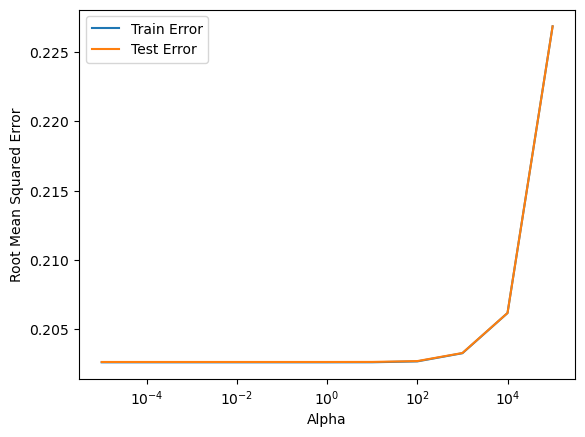

Best Alpha: 0.1
Best RMSE: 0.20259593020327787


In [315]:
alphas = np.logspace(-5, 5, num=11)

rmse_scores_test = []
rmse_scores_train = []

for alpha in alphas:
    test_errors, train_errors = k_fold_cross_validation(RidgeRegression(alpha = alpha), X=X_num, y=y_num, evaluation_method='rmse', random_state=42)
    rmse_test = np.mean(test_errors)
    rmse_scores_test.append(rmse_test)
    rmse_train = np.mean(train_errors)
    rmse_scores_train.append(rmse_train)

plt.plot(alphas, rmse_scores_train, label='Train Error')
plt.plot(alphas, rmse_scores_test, label='Test Error')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

best_alpha_idx = np.argmin(rmse_scores_test)
best_alpha = alphas[best_alpha_idx]
best_rmse = rmse_scores_test[best_alpha_idx]

print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

R2 train test

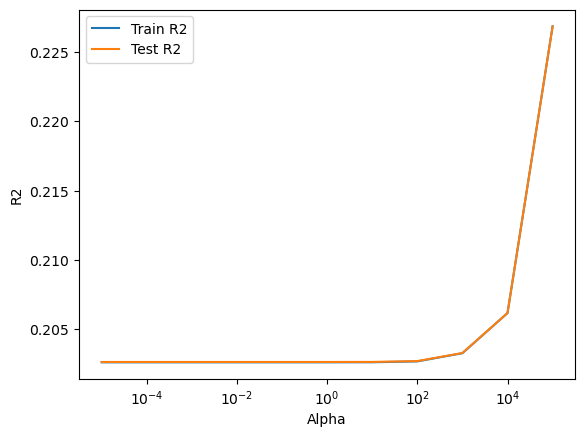

Best Alpha: 0.1
Best R2: 0.030907578773781964


In [316]:
alphas = np.logspace(-5, 5, num=11)

r2_scores_test = []
r2_scores_train = []

for alpha in alphas:
    test_errors, train_errors = k_fold_cross_validation(RidgeRegression(alpha = alpha), X=X_num, y=y_num, evaluation_method='r2', random_state=42)
    r2_test = np.mean(test_errors)
    r2_scores_test.append(r2_test)
    r2_train = np.mean(train_errors)
    r2_scores_train.append(r2_train)

plt.plot(alphas, rmse_scores_train, label='Train R2')
plt.plot(alphas, rmse_scores_test, label='Test R2')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R2')
plt.legend()
plt.show()

best_alpha_idx = np.argmax(r2_scores_test)
best_alpha = alphas[best_alpha_idx]
best_r2 = r2_scores_test[best_alpha_idx]

print("Best Alpha:", best_alpha)
print("Best R2:", best_r2)

[-0.21746057  0.09708478 -0.021904    0.04029311 -0.11598052 -0.01620766
 -0.08808466  0.00631164 -0.08189077  0.00791591  0.03874632]


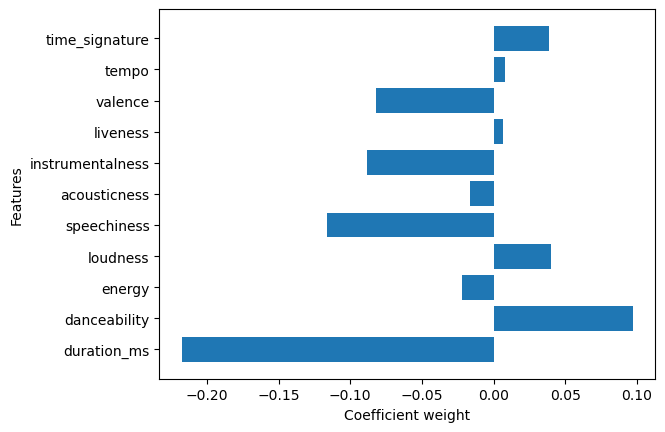

In [317]:
best_model = RidgeRegression(alpha=best_alpha)

best_model.fit(X_num_train, y_num_train)

coef = best_model.coef_
print(coef)

plt.barh(numerical_vars, coef)
plt.xlabel('Coefficient weight')
plt.ylabel('Features')
plt.show()

# ols_model = RidgeRegression(alpha=0)

# ols_model.fit(X_num_train, y_num_train)

# linear_model_coef = ols_model.coef_

# plt.barh(numerical_vars, linear_model_coef)
# plt.xlabel('Coefficient weight')
# plt.ylabel('Features')
# plt.show()

In [318]:
nested_cv_estimate, best_hyper_par_list, errors = nested_cross_validation(X_num, y_num, evaluation_method='rmse', alpha_list=np.logspace(-5, 5, num=11), random_state=42)

In [319]:
nested_cv_estimate

0.20259593348871854

In [320]:
best_hyper_par_list, errors

([1e-05, 0.0001, 0.01, 0.01, 0.0001],
 [0.2015406388182304,
  0.20367665537984433,
  0.2025498761673025,
  0.2032948185803825,
  0.20191767849783296])

### Ridge regression with categorical data

In [321]:
X = df.drop(columns='popularity')
y = df['popularity']

In [322]:
X_train, X_test, y_train, y_test = train_test_split_manual(X, y, random_state=42)

In [323]:
# Model with the average popularity in training set as predictor
test_errors, train_errors = k_fold_cross_validation(MeanModel(), X=X, y=y, evaluation_method='rmse', random_state=42)
rmse_test = np.mean(test_errors)
rmse_train = np.mean(train_errors)
test_r2_scores, train_r2_scores = k_fold_cross_validation(MeanModel(), X=X, y=y, evaluation_method='r2', random_state=42)
test_r2 = np.mean(test_r2_scores)
train_r2 = np.mean(train_r2_scores)
print("RMSE Training Set Mean Model:", rmse_train)
print("RMSE Test Set Mean Model:", rmse_test)
print("")
print("R2 Training Set Mean Model:", train_r2)
print("R2 Test Set Mean Model:", test_r2)


RMSE Training Set Mean Model: 0.2058050252185512
RMSE Test Set Mean Model: 0.20580506263794515

R2 Training Set Mean Model: 0.0
R2 Test Set Mean Model: -3.424202923669739e-05


In [324]:
# Model with OLS regression
test_errors, train_errors = k_fold_cross_validation(RidgeRegression(0), X=X, y=y, evaluation_method='rmse', random_state=42)
rmse_test = np.mean(test_errors)
rmse_train = np.mean(train_errors)
test_r2_scores, train_r2_scores = k_fold_cross_validation(RidgeRegression(0), X=X, y=y, evaluation_method='r2', random_state=42)
test_r2 = np.mean(test_r2_scores)
train_r2 = np.mean(train_r2_scores)
print("RMSE Training Set OLS Model:", rmse_train)
print("RMSE Test Set OLS Model:", rmse_test)
print("")
print("R2 Training Set OLS Model:", train_r2)
print("R2 Test Set OLS Model:", test_r2)


RMSE Training Set OLS Model: 0.16836424276857329
RMSE Test Set OLS Model: 0.16868984475261678

R2 Training Set OLS Model: 0.3307493610012685
R2 Test Set OLS Model: 0.32811183914153846


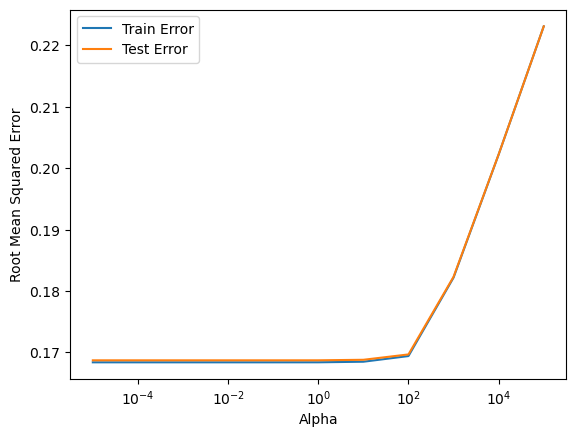

Best Alpha: 0.1
Best RMSE: 0.168689734814298


In [325]:
alphas = np.logspace(-5, 5, num=11)
# alphas = np.logspace(0, 5, num=30)
# alphas = np.linspace(0, 100, num=101)
# alphas = [0, 1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 10000]
# alphas = np.logspace(-10, 10, num=21)
# alphas = np.insert(alphas, 0, 0)

rmse_scores_test = []
rmse_scores_train = []

for alpha in alphas:
    test_errors, train_errors = k_fold_cross_validation(RidgeRegression(alpha = alpha), X=X, y=y, evaluation_method='rmse', random_state=42)
    rmse_test = np.mean(test_errors)
    rmse_scores_test.append(rmse_test)
    rmse_train = np.mean(train_errors)
    rmse_scores_train.append(rmse_train)

plt.plot(alphas, rmse_scores_train, label='Train Error')
plt.plot(alphas, rmse_scores_test, label='Test Error')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

best_alpha_idx = np.argmin(rmse_scores_test)
best_alpha = alphas[best_alpha_idx]
best_rmse = rmse_scores_test[best_alpha_idx]

print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

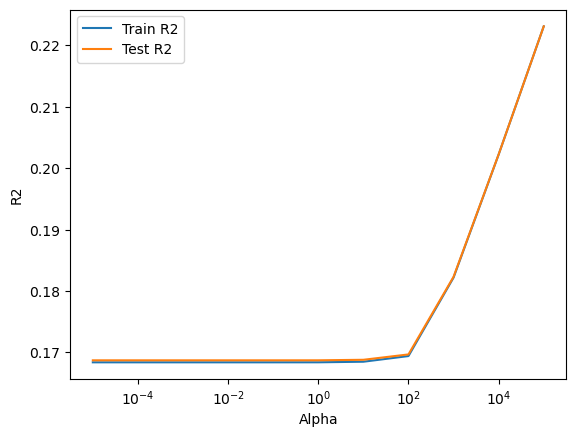

Best Alpha: 0.1
Best R2: 0.32811263048805006


In [326]:
alphas = np.logspace(-5, 5, num=11)

r2_scores_test = []
r2_scores_train = []

for alpha in alphas:
    test_errors, train_errors = k_fold_cross_validation(RidgeRegression(alpha = alpha), X=X, y=y, evaluation_method='r2', random_state=42)
    r2_test = np.mean(test_errors)
    r2_scores_test.append(r2_test)
    r2_train = np.mean(train_errors)
    r2_scores_train.append(r2_train)

plt.plot(alphas, rmse_scores_train, label='Train R2')
plt.plot(alphas, rmse_scores_test, label='Test R2')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R2')
plt.legend()
plt.show()

best_alpha_idx = np.argmax(r2_scores_test)
best_alpha = alphas[best_alpha_idx]
best_r2 = r2_scores_test[best_alpha_idx]

print("Best Alpha:", best_alpha)
print("Best R2:", best_r2)

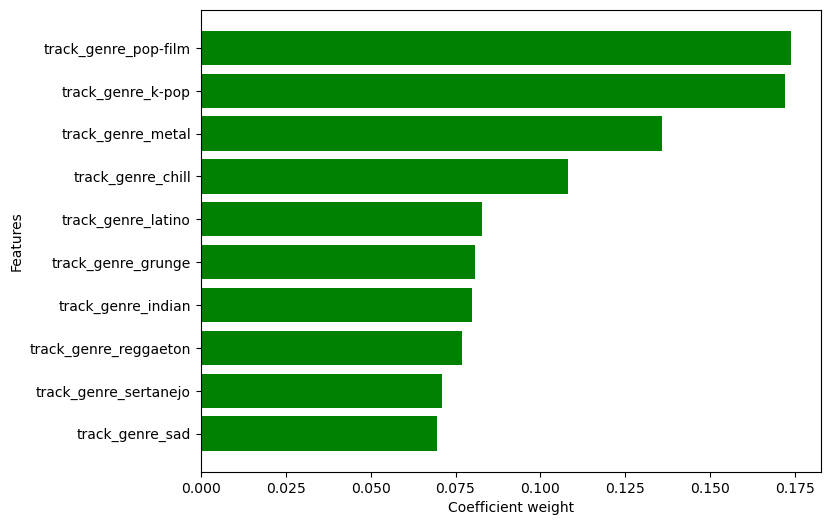

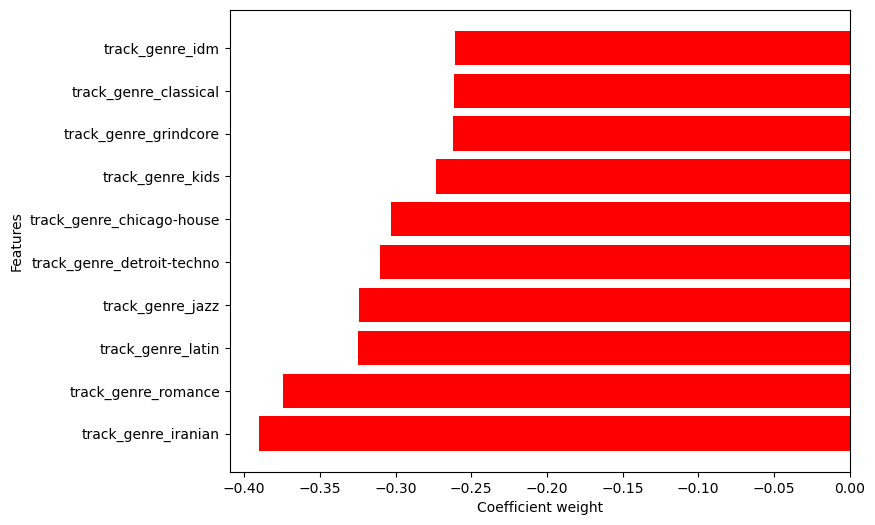

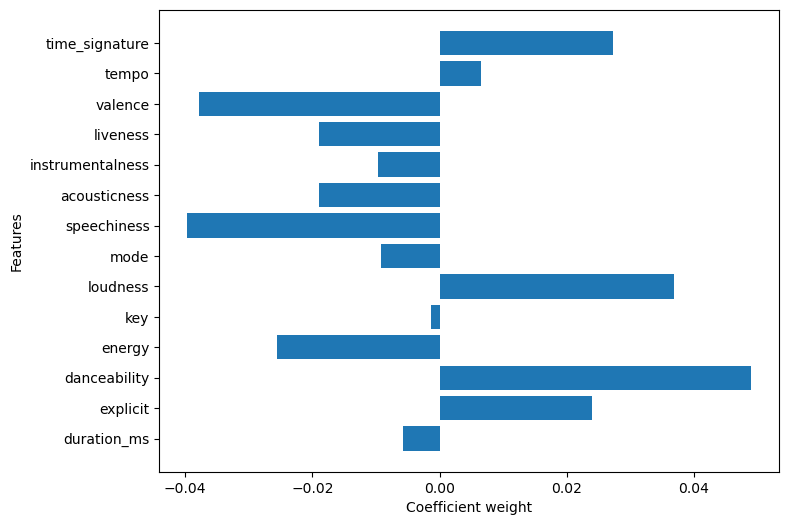

In [327]:
best_model = RidgeRegression(alpha=best_alpha)

best_model.fit(X_train, y_train)

coef = best_model.coef_

# Get the indices of the top 10 highest and lowest coefficients
top_10_highest_indices = np.argsort(coef)[-10:]
top_10_lowest_indices = np.argsort(coef)[:10]

# Get the top 10 highest and lowest coefficients and their corresponding feature names
top_10_highest_coef = coef[top_10_highest_indices]
top_10_highest_features = X_train.columns[top_10_highest_indices]

top_10_lowest_coef = coef[top_10_lowest_indices]
top_10_lowest_features = X_train.columns[top_10_lowest_indices]

# Plot the top 10 highest coefficients
plt.figure(figsize=(8, 6))
plt.barh(top_10_highest_features, top_10_highest_coef, color='green')
plt.xlabel('Coefficient weight')
plt.ylabel('Features')
plt.show()

# Plot the top 10 lowest coefficients
plt.figure(figsize=(8, 6))
plt.barh(top_10_lowest_features, top_10_lowest_coef, color='red')
plt.xlabel('Coefficient weight')
plt.ylabel('Features')
plt.show()

feature_names = X_train.columns

# Filter out features that start with "track_genre"
non_track_genre_mask = ~feature_names.str.startswith('track_genre')
non_track_genre_features = feature_names[non_track_genre_mask]
non_track_genre_coef = coef[non_track_genre_mask]

# Plot the coefficients for the filtered features
plt.figure(figsize=(8, 6))
plt.barh(non_track_genre_features, non_track_genre_coef)
plt.xlabel('Coefficient weight')
plt.ylabel('Features')
plt.show()

In [147]:
nested_cross_validation(X, y, evaluation_method='rmse', alpha_list=np.logspace(-5, 5, num=11), random_state=42)

(0.1686543723666267,
 [10.0, 0.0001, 10.0, 10.0, 0.01],
 [0.16821892758543827,
  0.17095688567535636,
  0.16904771687246303,
  0.16956134558198507,
  0.16548698611789078])